In [1]:
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.preprocessing import QuantileTransformer

In [2]:
data = pd.read_csv(r"C:\Zhongming Lu\hk_bld\eui\final data\hk_eui_sample_for_analysis.csv",index_col=0,encoding='ISO-8859-1')
data = data.drop(['dist_searc','AddressofB','Expiry_dat','BEC_name','BEC_addres','Date_FOC','Date_EA','Date_FoC_1',
                 'x','y','result_cod','English_bu','Street_No','E_Estate_N',
                 'District','bld_x','bld_y','bld_code','TPU','Shape_Leng'],axis=1)
data = data[(data.TPU_join>0) & (data.bld_info_j>0) & (data.manual_che == 0)]
data = data[ (data.highrise_j>0) | (data.podium_j>0) ]
data = data[(data.kWh_m2_ann>10) & (data.kWh_m2_ann<400)]
data = data[(data.Year_Built>0) & (data.No_of_Stor>0)]

In [3]:
data['Area'] = np.where(data['highrise'] == 1, data['highrise_a'], data['podium_are'])

In [4]:
data['retro_before'] = np.where(data['retro']=='Before',1,0)
data['retro_after'] = np.where(data['retro']=='After',1,0)

In [5]:
data['log_area'] = np.log10(data['Area']+1)
data['log_hotel_kern'] = np.log10(data['hotel_kern']+1)
data['log_retail_ker'] = np.log10(data['retail_ker']+1)
data['log_parking_ke'] = np.log10(data['parking_ke']+1)
data['log_food_kerne'] = np.log10(data['food_kerne']+1)
data['log_office_ker'] = np.log10(data['office_ker']+1)

In [6]:
data['log_mtr_dist'] = np.log10(data['mtr_dist'])

In [7]:
data['commercial'] = np.where(data['RASTERVALU']==11,1,0)

In [8]:
y = data['kWh_m2_ann'].reset_index(drop=True)

In [9]:
log_y = np.log10(y)

In [10]:
log_eui_median = log_y.median()
log_eui_median

1.778729923996112

In [11]:
log_eui_mean = log_y.mean()
pow(10,log_eui_mean)

61.358228803971876

In [12]:
y.mean()

86.15843660629169

In [13]:
#log_y_reshape = log_y.to_numpy().reshape(-1,1)

In [14]:
#qt = QuantileTransformer(n_quantiles = 20, output_distribution = 'normal', random_state= 8000)
#log_y_transform = qt.fit_transform(log_y_reshape)

In [15]:
#log_y_transform_s = pd.Series(log_y_transform.flatten())

In [16]:
log_y_category = pd.cut(log_y, bins=5)
log_y_weight = compute_sample_weight('balanced',log_y_category)

In [17]:
#Weight adjustment
for i in range(len(log_y)):
    if log_y[i]<=1.2 or log_y[i]>2.25:
        log_y_weight[i] = log_y_weight[i]*32
    elif log_y[i]>1.75 and log_y[i]<1.85:
        log_y_weight[i] = log_y_weight[i]/16
    else:
        log_y_weight[i] = log_y_weight[i]*6

In [18]:
X = data[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','is_commercial']].reset_index(drop=True)

In [19]:
seed = 8000

In [15]:
rf = RandomForestRegressor(random_state = seed, criterion='mse')

In [16]:
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 500, num = 50)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(3, 10, num = 20)]
max_depth.append(None)
min_samples_split = [8, 10, 12, 14, 16, 18, 20, 30]
min_samples_leaf = [4, 6, 8]
bootstrap = [True, False]

In [20]:
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 500, cv = 5, verbose=2, random_state= seed, n_jobs = -1, scoring='r2')

In [22]:
rf_random.fit(X, log_y, sample_weight=log_y_weight)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:  7.5min finished


RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(random_state=8000),
                   n_iter=500, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [3, 3, 3, 4, 4, 4, 5, 5, 5,
                                                      6, 6, 7, 7, 7, 8, 8, 8, 9,
                                                      9, 10, None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [4, 6, 8],
                                        'min_samples_split': [8, 10, 12, 14, 16,
                                                              18, 20, 30],
                                        'n_estimators': [10, 20, 30, 40, 50, 60,
                                                         70, 80, 90, 100, 110,
                                                         

In [23]:
rf_random.best_params_

{'n_estimators': 80,
 'min_samples_split': 12,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [24]:
rf = RandomForestRegressor(random_state = seed,
                          n_estimators=rf_random.best_params_['n_estimators'],
                          min_samples_split=rf_random.best_params_['min_samples_split'],
                          min_samples_leaf=rf_random.best_params_['min_samples_leaf'],
                          max_features=rf_random.best_params_['max_features'],
                          max_depth=rf_random.best_params_['max_depth'],
                          bootstrap=rf_random.best_params_['bootstrap'])

In [62]:
rf_best = rf_random.best_estimator_

In [20]:
#best_params_={'n_estimators': 130,
# 'min_samples_split': 6,
# 'min_samples_leaf': 6,
# 'max_features': 'log2',
# 'max_depth': 11,
# 'bootstrap': False}

#best_params_={'n_estimators': 50,
# 'min_samples_split': 20,
# 'min_samples_leaf': 6,
# 'max_features': 'log2',
# 'max_depth': 20,
# 'bootstrap': True}

#best_params_={'n_estimators': 87,
# 'min_samples_split': 6,
# 'min_samples_leaf': 2,
# 'max_features': 'sqrt',
# 'max_depth': 14,
# 'bootstrap': True}

best_params_={'n_estimators': 80,
 'min_samples_split': 12,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [21]:
rf = RandomForestRegressor(random_state = seed,
                          n_estimators=best_params_['n_estimators'],
                          min_samples_split=best_params_['min_samples_split'],
                          min_samples_leaf=best_params_['min_samples_leaf'],
                          max_features=best_params_['max_features'],
                          max_depth=best_params_['max_depth'],
                          bootstrap=best_params_['bootstrap'])

In [22]:
cv = KFold(n_splits=5, random_state=seed, shuffle=True)

for (train, test), i in zip(cv.split(X, log_y), range(5)):
    rf.fit(X.iloc[train], log_y.iloc[train],sample_weight = log_y_weight[train])
    log_y_pred = rf.predict(X.iloc[test])
    log_y_true = log_y.loc[test].values
    
    accuracy_num = 0 
    
    for i in range(len(log_y_pred)):
        if log_y_true[i] > log_eui_median:
            if log_y_pred[i] > log_eui_median:
                accuracy_num = accuracy_num + 1
        if log_y_true[i] <= log_eui_median:
            if log_y_pred[i] <= log_eui_median:
                accuracy_num = accuracy_num + 1
                
    rmse_test = metrics.mean_squared_error(log_y.iloc[test], log_y_pred, squared=False)
    r2_test = metrics.r2_score(log_y.loc[test],log_y_pred)
    accuarcy_test = "{:.2%}".format(accuracy_num/len(log_y_pred))
    print ('RMSE: %.4f'%rmse_test)
    print ('R2: %.4f'%r2_test)
    print ('Accuracy: ', accuarcy_test)

RMSE: 0.3142
R2: 0.2916
Accuracy:  73.81%
RMSE: 0.3016
R2: 0.3277
Accuracy:  71.90%
RMSE: 0.2949
R2: 0.3706
Accuracy:  77.14%
RMSE: 0.2999
R2: 0.3382
Accuracy:  71.90%
RMSE: 0.2970
R2: 0.2895
Accuracy:  71.77%


In [23]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["savefig.dpi"] = 300
plt.rcParams['axes.spines.top'] = True
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.right'] = True
plt.rcParams.update({'font.size': 30})

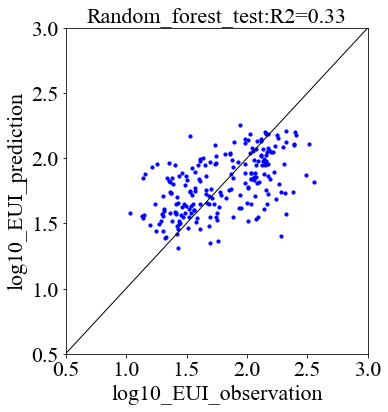

In [21]:
fig, ax = plt.subplots(1,1,figsize=(6,6))
ax.scatter(log_y.iloc[test], log_y_pred, color='b', s=10)    
ax.plot([-10,10],[-10,10], color='k', linewidth=1)
ax.set_xlim([0.5,3])
ax.set_ylim([0.5,3])
ax.tick_params(axis='both', which='major', labelsize=22)
ax.set_title("Random_forest_test:R2=0.33", fontsize=22)
#ax.annotate('R2=0.31',(1.5,2.5), fontsize=22)
#ax.set_title("%f Error Plot"%(r2_score(log_y.iloc[test],log_y_pred)), fontsize=17)
#ax.set_title("%f Error Plot"%(mean_squared_error(log_y_transform_s,log_y_transform_pred,squared=False)), fontsize=17)
ax.set_xlabel("log10_EUI_observation", fontsize=22)
ax.set_ylabel("log10_EUI_prediction", fontsize=22)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.yaxis.set_major_locator(plt.MaxNLocator(5))

plt.subplots_adjust(left=0.2,right=0.9)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\random_forest_test.png')

plt.show()
plt.close()

In [28]:
log_y_pred = rf.predict(X)#.iloc[test])
#log_y_pred = qt.inverse_transform(log_y_transform_pred.reshape(-1,1))

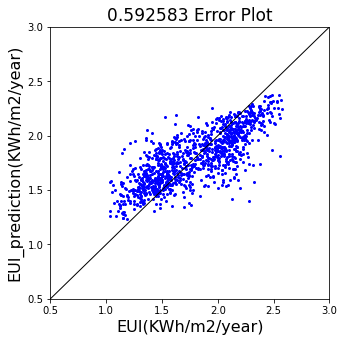

In [29]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.scatter(log_y, log_y_pred, color='b', s=4, label="Predicted")    
ax.plot([-10,10],[-10,10], color='k', linewidth=1)
ax.set_xlim([0.5,3])
ax.set_ylim([0.5,3])
ax.set_title("%f Error Plot"%(metrics.r2_score(log_y, log_y_pred)), fontsize=17)
#ax.set_title("%f Error Plot"%(metrics.mean_squared_error(log_y_reset,log_y_pred,squared=False)), fontsize=17)
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=16)
ax.set_ylabel("EUI_prediction(KWh/m2/year)", fontsize=16)
plt.show()
plt.close()

In [30]:
rf.feature_importances_

array([0.01980194, 0.02800451, 0.08672246, 0.05173405, 0.10900152,
       0.07326986, 0.06346257, 0.04571719, 0.19291552, 0.06874823,
       0.10967617, 0.00568314, 0.05529143, 0.08204033, 0.00793108])

<BarContainer object of 15 artists>

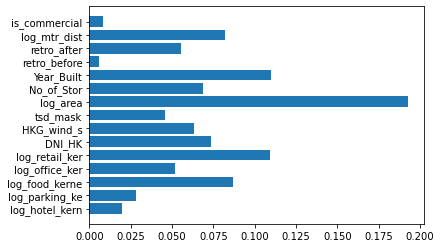

In [31]:
plt.barh(X.columns, rf.feature_importances_)

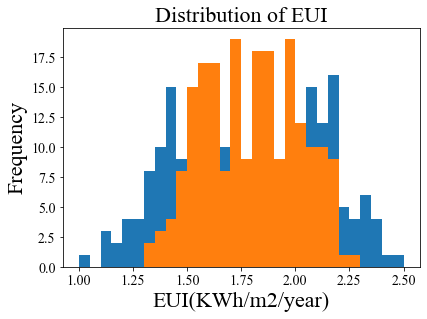

In [42]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))

plt.hist(log_y_true,bins=30, range=[1.00,2.50])
plt.hist(log_y_pred,bins=30, range=[1.00,2.50])

ax.set_title("Distribution of EUI", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()

# Shapley Interpretation

In [24]:
import shap

In [25]:
explainer = shap.Explainer(rf, algorithm='auto')

In [26]:
shap_values = explainer(X)

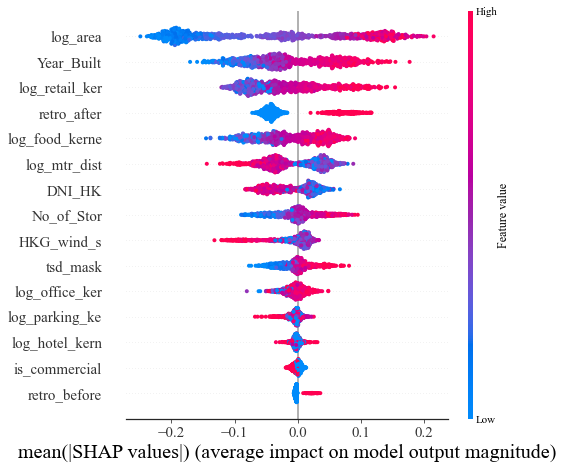

In [70]:
shap.plots.beeswarm(shap_values, max_display=15, show=False)

plt.xlabel('mean(|SHAP values|) (average impact on model output magnitude)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)

plt.subplots_adjust(left=0.2,right=0.9)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\random_forest_shap.png')

In [27]:
shap_values_dep = explainer.shap_values(X)

In [31]:
X_name = ['log10_hotel_ker','log10_parking_ker','log10_food_ker','log10_office_ker','log10_retail_ker',
          'DNI','wind_speed_10m','CDH','log10_area','No_of_Stor','year_built',
          'retro_before_audit','retro_after_audit','log10_mtr_dist','is_commercial_land_use']

In [32]:
X_shap = []

In [34]:
for i in range(len(X_name)):
    X_shap.append(abs(shap_values_dep[:,i]).mean())

In [35]:
X_mean_shap = pd.DataFrame({'X_name':X_name,
                            'X_shap':X_shap})

In [36]:
X_mean_shap.to_csv(r'C:\Zhongming Lu\hk_bld\eui\x_mean_shap_rf.csv',index=False, header=True)

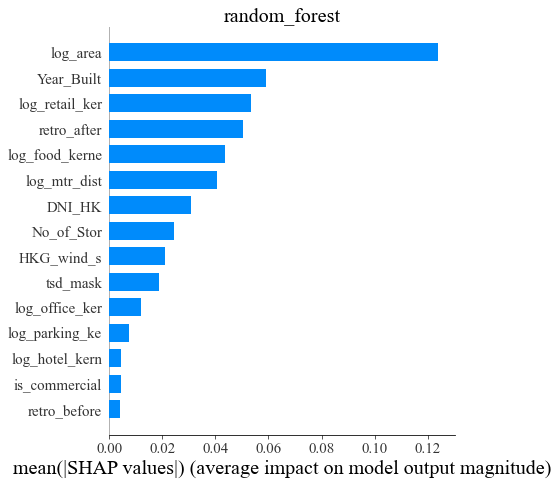

In [28]:
shap.summary_plot(shap_values_dep, X, plot_type="bar", show=False)
plt.xlabel('mean(|SHAP values|) (average impact on model output magnitude)',fontsize=20)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.title('random_forest',loc='center',fontsize=20)

plt.subplots_adjust(left=0.2,right=0.8)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\random_forest_shap.png')

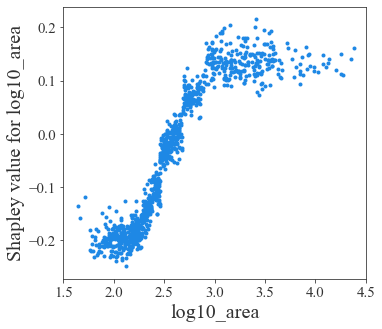

In [30]:
shap.dependence_plot("log_area",shap_values_dep, X, xmin=1.5, xmax=4.5, interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('log10_area',fontsize=20)
plt.ylabel('Shapley value for log10_area',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_log_area.png',dpi=300)
plt.show()

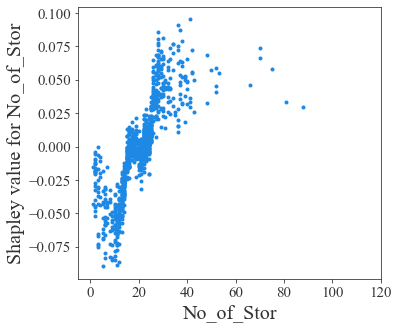

In [29]:
shap.dependence_plot("No_of_Stor",shap_values_dep, X, xmin=1, xmax=120, interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('No_of_Stor',fontsize=20)
plt.ylabel('Shapley value for No_of_Stor',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_No_of_Stor.png',dpi=300)
plt.show()

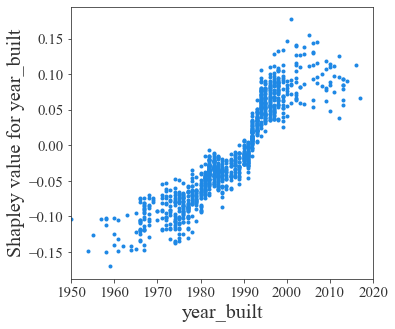

In [31]:
shap.dependence_plot("Year_Built",shap_values_dep, X, xmin=1950, xmax=2020, interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('year_built',fontsize=20)
plt.ylabel('Shapley value for year_built',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_year_built.png',dpi=300)
plt.show()

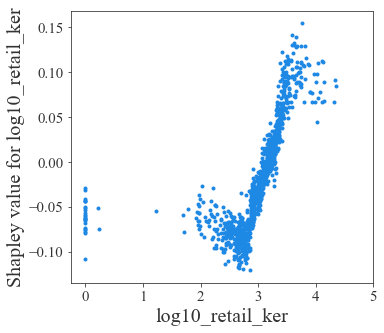

In [33]:
shap.dependence_plot("log_retail_ker",shap_values_dep, X, xmin=0, xmax=5,interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('log10_retail_ker',fontsize=20)
plt.ylabel('Shapley value for log10_retail_ker',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_log10_retail_ker.png',dpi=300)
plt.show()

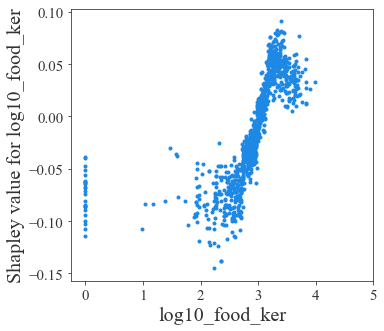

In [34]:
shap.dependence_plot("log_food_kerne",shap_values_dep, X, xmin=0, xmax=5,interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('log10_food_ker',fontsize=20)
plt.ylabel('Shapley value for log10_food_ker',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_log10_food_ker.png',dpi=300)
plt.show()

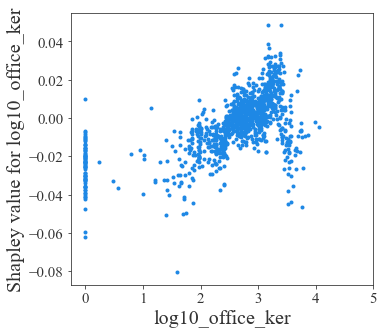

In [35]:
shap.dependence_plot("log_office_ker",shap_values_dep, X, xmin=0, xmax=5,interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('log10_office_ker',fontsize=20)
plt.ylabel('Shapley value for log10_office_ker',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_log10_office_ker.png',dpi=300)
plt.show()

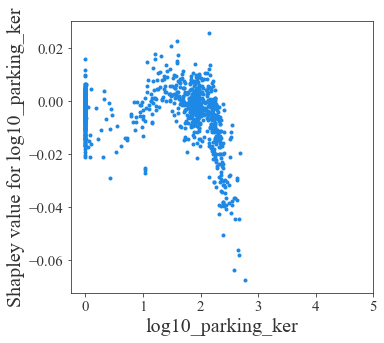

In [36]:
shap.dependence_plot("log_parking_ke",shap_values_dep, X, xmin=0, xmax=5,interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('log10_parking_ker',fontsize=20)
plt.ylabel('Shapley value for log10_parking_ker',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_log10_parking_ker.png',dpi=300)
plt.show()

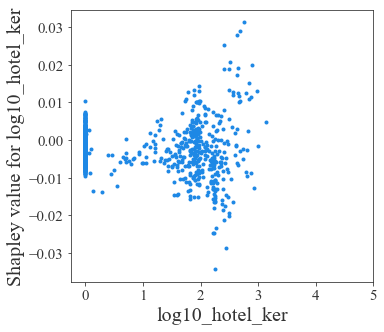

In [37]:
shap.dependence_plot("log_hotel_kern",shap_values_dep, X, xmin=0, xmax=5,interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('log10_hotel_ker',fontsize=20)
plt.ylabel('Shapley value for log10_hotel_ker',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_log10_hotel_ker.png',dpi=300)
plt.show()

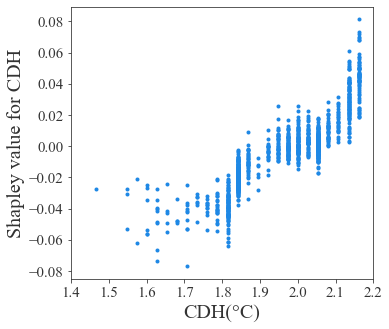

In [51]:
shap.dependence_plot("tsd_mask",shap_values_dep, X,  xmin=1.4, xmax=2.2,interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('CDH(°C)',fontsize=20)
plt.ylabel('Shapley value for CDH',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_CDH.png',dpi=300)
plt.show()

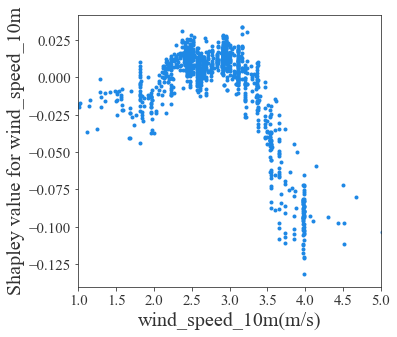

In [50]:
shap.dependence_plot("HKG_wind_s",shap_values_dep, X, xmin=1, xmax=5, interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('wind_speed_10m(m/s)',fontsize=20)
plt.ylabel('Shapley value for wind_speed_10m',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_wind_speed_10m.png',dpi=300)
plt.show()

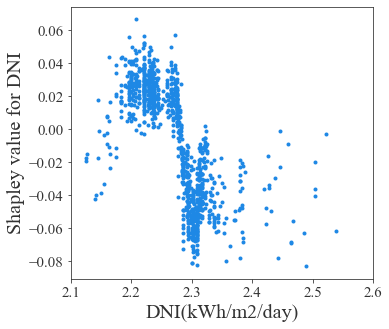

In [57]:
shap.dependence_plot("DNI_HK",shap_values_dep, X, xmin=2.1, xmax=2.6,interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('DNI(kWh/m2/day)',fontsize=20)
plt.ylabel('Shapley value for DNI',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_DNI.png',dpi=300)
plt.show()

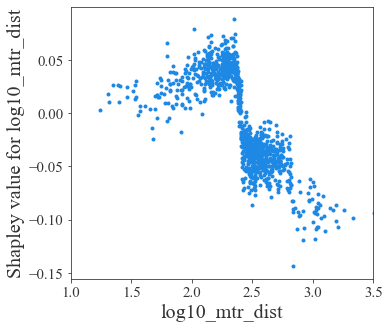

In [28]:
shap.dependence_plot("log_mtr_dist",shap_values_dep, X, xmin=1, xmax=3.5, interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
plt.xticks(fontsize=15)
plt.xlabel('log10_mtr_dist',fontsize=20)
plt.ylabel('Shapley value for log10_mtr_dist',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_log10_mtr_dist.png',dpi=300)
plt.show()

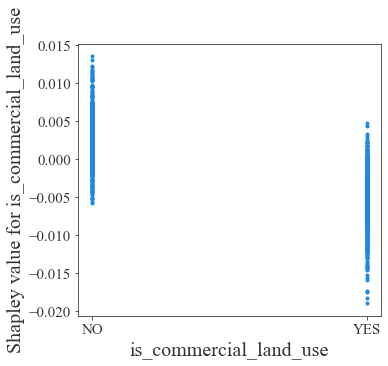

In [33]:
shap.dependence_plot("is_commercial",shap_values_dep, X, interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('is_commercial_land_use',fontsize=20)
plt.ylabel('Shapley value for is_commercial_land_use',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_is_commercial_land_use.png',dpi=300)
plt.show()

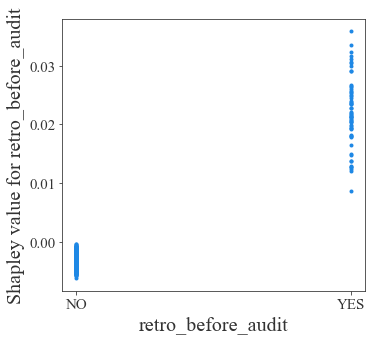

In [37]:
shap.dependence_plot("retro_before",shap_values_dep, X, interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('retro_before_audit',fontsize=20)
plt.ylabel('Shapley value for retro_before_audit',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_retro_before_audit.png',dpi=300)
plt.show()

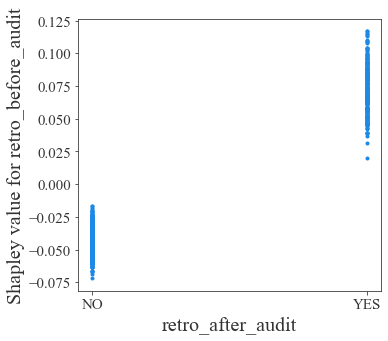

In [38]:
shap.dependence_plot("retro_after",shap_values_dep, X, interaction_index=None,show=False,ax=None)

plt.subplots_adjust(left=0.2,right=0.9)
plt.yticks(fontsize=15)
x = [0,1]
label = ['NO','YES']
plt.xticks(x,label,fontsize=15)
plt.xlabel('retro_after_audit',fontsize=20)
plt.ylabel('Shapley value for retro_before_audit',fontsize=20)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['top'].set_visible(True)

plt.savefig(r'C:\Users\zhongminglu\OneDrive - HKUST\Paper 13\shap_retro_after_audit.png',dpi=300)
plt.show()

# Save Model

#  City Commercial Building EUI Map

In [38]:
rf.fit(X, log_y,sample_weight=log_y_weight)

RandomForestRegressor(max_depth=10, max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=12, n_estimators=80, random_state=8000)

In [39]:
data_1 = pd.read_csv(r"C:\Zhongming Lu\hk_bld\bld\hk_commercial_bld\hk_commercial_bld_for_analysis.csv",index_col=0,encoding='ISO-8859-1')
data_1 = data_1[ (data_1.highrise_j>0) | (data_1.podium_j>0) ]
data_1['Area'] = np.where(data_1['highrise'] == 1, data_1['highrise_a'], data_1['podium_are'])
data_1['retro_before'] = 0
data_1['retro_after'] = 0
data_1['log_area'] = np.log10(data_1['Area']+1)
data_1['log_hotel_kern'] = np.log10(data_1['hotel_kern']+1)
data_1['log_retail_ker'] = np.log10(data_1['retail_ker']+1)
data_1['log_parking_ke'] = np.log10(data_1['parking_ke']+1)
data_1['log_food_kerne'] = np.log10(data_1['food_kerne']+1)
data_1['log_office_ker'] = np.log10(data_1['office_ker']+1)
data_1['log_mtr_dist'] = np.log10(data_1['mtr_dist'])
data_1['commercial'] = np.where(data_1['RASTERVALU']==11,1,0)
data_1['is_commercial'] = data_1['is_commerc']

In [40]:
X_1 = data_1[['log_hotel_kern','log_parking_ke','log_food_kerne','log_office_ker','log_retail_ker','DNI_HK','HKG_wind_s','tsd_mask','log_area',
         'No_of_Stor','Year_Built','retro_before','retro_after','log_mtr_dist','is_commercial']]

In [41]:
log_y_pred = rf.predict(X_1) 

In [42]:
y_pred = np.power(10, log_y_pred)

In [43]:
data_1['eui_pred'] = y_pred

In [44]:
data_1.to_csv(r'C:\Zhongming Lu\hk_bld\eui\full_c_bld_eui_pred.csv',index=False, header=True)

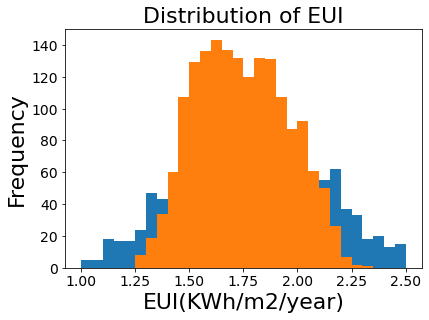

In [45]:
fig, ax = plt.subplots(1,1,figsize=(6.4,4.4))

plt.hist(log_y,bins=30, range=[1.00,2.50])
plt.hist(log_y_pred,bins=30, range=[1.00,2.50])

ax.set_title("Distribution of EUI", fontsize=22, color='k')
ax.set_ylabel("Frequency", fontsize=22, color='k')
ax.set_xlabel("EUI(KWh/m2/year)", fontsize=22, color='k')
ax.tick_params(axis='both', which='major', labelsize=14)

plt.show()
plt.close()